Tutorial References: 

https://www.tensorflow.org/text/tutorials/text_classification_rnn 

https://colab.research.google.com/drive1CVZ4NTO3NRYNDV1MWxvx5Y5HKtgt0OCo#scrollTo=w3GM0KmD_gsU

https://huggingface.co/docs/transformers/tasks/sequence_classification

In [5]:
# having error when importing HC3 dataset from HuggingFace so using local downloaded file
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir("/content/drive/MyDrive/AI/RNN/Iteration0")

In [ ]:
!pip install datasets
!pip install ntlk

In [3]:
from datasets import load_dataset
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

#For cleaning
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import spacy
import re
import string


#For evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Please adjust this path to the AI folder in your drive

Load datasets 
Process them to ensure that for each row there is one human answer only. For both datasets, 1 question can have multiple human answers

In [9]:
#load local HC3 data
hc3_df = pd.read_csv("eli5_clean_combined.csv")
hc3_df

,response,Label
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0
...,...,...
33165,It's difficult to say exactly why the general ...,1
33166,Infrared light is a type of light that we can'...,1
33167,"Cars are not just about how fast they can go, ...",1
33168,A CO2 scrubber is a device that removes carbon...,1


In [10]:
from statistics import mean, median
import numpy as np
human_df = hc3_df[hc3_df["Label"]==0]
human_text_length_list = [len(txt) for txt in human_df["response"]]
print(f"Min: {min(human_text_length_list)}")
print(f"25th Percentile: {np.percentile(human_text_length_list, 25)}")
print(f"Median: {median(human_text_length_list)}")
print(f"75th Percentile: {np.percentile(human_text_length_list, 75)}")
print(f"Max: {max(human_text_length_list)}")

Min: 25
25th Percentile: 244.0
Median: 475
75th Percentile: 914.0
Max: 36793


In [12]:
from statistics import mean, median
gpt_df = hc3_df[hc3_df["Label"]==1]
gpt_text_length_list = [len(txt) for txt in gpt_df["response"]]
print(f"Min: {min(gpt_text_length_list)}")
print(f"25th Percentile: {np.percentile(gpt_text_length_list, 25)}")
print(f"Median: {median(gpt_text_length_list)}")
print(f"75th Percentile: {np.percentile(gpt_text_length_list, 75)}")
print(f"Max: {max(gpt_text_length_list)}")

Min: 54
25th Percentile: 781.0
Median: 991
75th Percentile: 1194.0
Max: 3508


Clean the Text for vectorisation

In [13]:
#Referenced: https://www.dataknowsall.com/textcleaning.html
def clean_string(text):
    final_string = ""
    # Make lower
    text = text.lower()
    # Remove line breaks
    text = re.sub(r'\n', '', text)
    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words
    text_filtered = [word for word in text if not word in useless_words]
    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
    lem = WordNetLemmatizer()
    text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    final_string = ' '.join(text_stemmed)
    return final_string


hc3_df["Cleaned_Text"] = hc3_df["response"].apply(lambda x: clean_string(x))

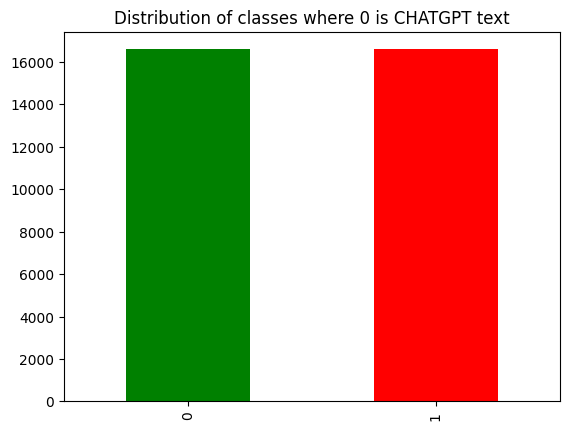

In [14]:
raw_df = hc3_df.copy()
count_Class=pd.value_counts(raw_df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes where 0 is CHATGPT text')
plt.show()

Train a basic RNN using Tensorflow

In [16]:
X = raw_df['Cleaned_Text'].values
y = raw_df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_train, tf.string),tf.cast(y_train, tf.int32))))
test_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_test, tf.string),tf.cast(y_test, tf.int32))))

In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Compile Model

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy','AUC'])

Train Model

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(train_dataset,epochs=3,validation_data=test_dataset,validation_steps=30,callbacks=[early_stop])

Epoch 1/3
363/363 [==============================] - 63s 114ms/step - loss: 0.4715 - accuracy: 0.7843 - auc: 0.8792 - val_loss: 0.2319 - val_accuracy: 0.9172 - val_auc: 0.9709
Epoch 2/3
363/363 [==============================] - 17s 47ms/step - loss: 0.1838 - accuracy: 0.9413 - auc: 0.9786 - val_loss: 0.1440 - val_accuracy: 0.9505 - val_auc: 0.9882
Epoch 3/3
363/363 [==============================] - 17s 48ms/step - loss: 0.1271 - accuracy: 0.9584 - auc: 0.9892 - val_loss: 0.1260 - val_accuracy: 0.9557 - val_auc: 0.9903


Evaluate Model

In [23]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

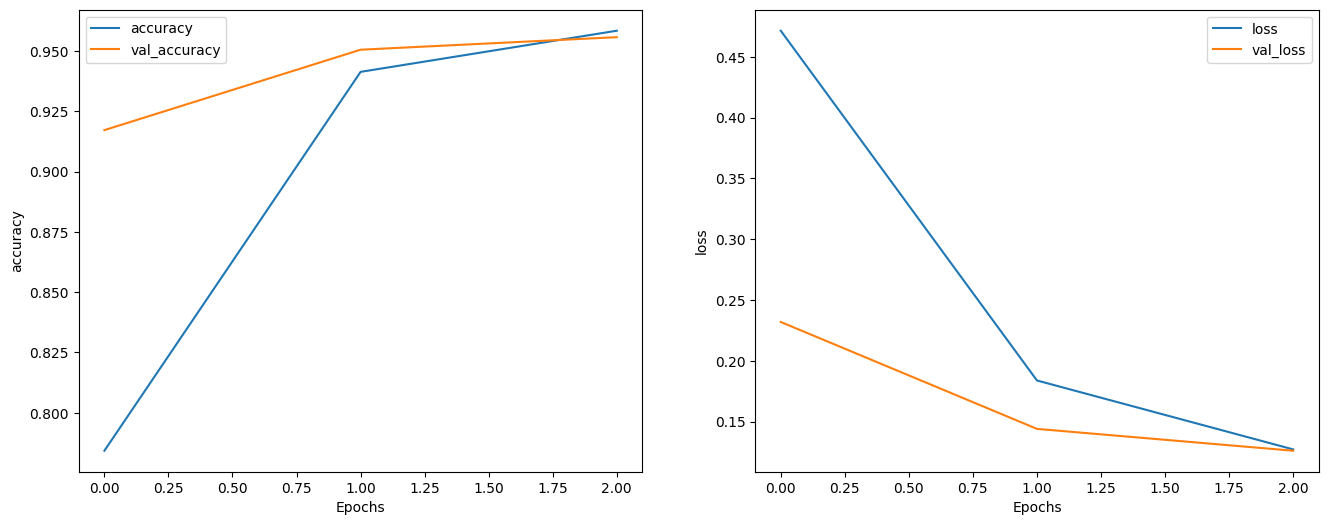

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [25]:
test_results = model.evaluate(test_dataset)
test_results

156/156 [==============================] - 3s 17ms/step - loss: 0.1213 - accuracy: 0.9575 - auc: 0.9914


[0.12125400453805923, 0.9574916958808899, 0.991381049156189]

156/156 [==============================] - 6s 18ms/step


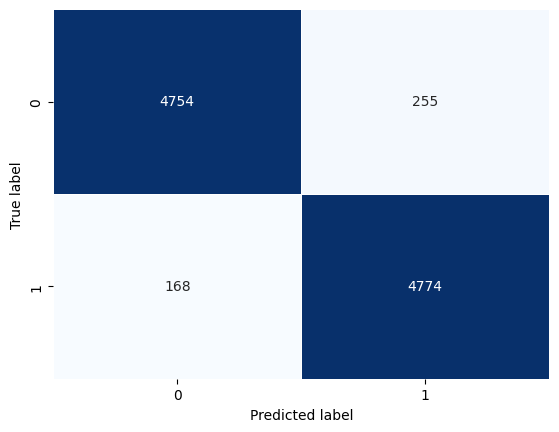

In [26]:
preds = (model.predict(test_dataset) > 0.5).astype("int32")
plot_confusion_matrix(y_test, preds)

Save Model

In [ ]:
current_directory = os.getcwd()
model.save(current_directory+"/basic_rnn_model")

Reload Saved Model

In [ ]:
saved_model = tf.keras.models.load_model("/content/drive/MyDrive/AI/RNN CNN/basic_rnn_model")

Looking into the oddly high accuracy of the baseline model: Cleaning Method with removal of stopwords may have cut out too many words

In [27]:
import seaborn as sns
import numpy as np

Text(0.5, 0.98, 'Distribution of Length of Text after Cleaning')

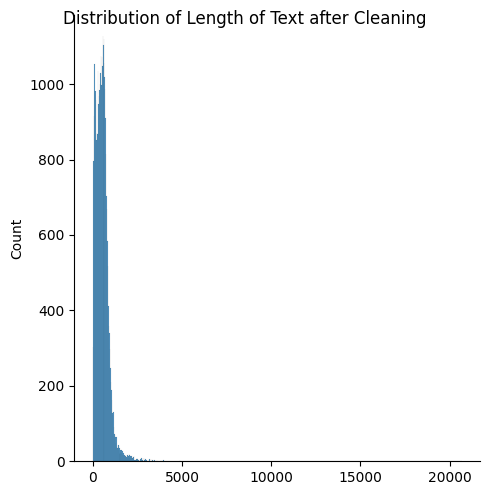

In [29]:
text_length_list = [len(txt) for txt in raw_df["Text"]]
cleaned_txt_length_hist = sns.displot(text_length_list)
cleaned_txt_length_hist.fig.suptitle('Distribution of Length of Text after Cleaning')

The mean length is 536
The median length is 493


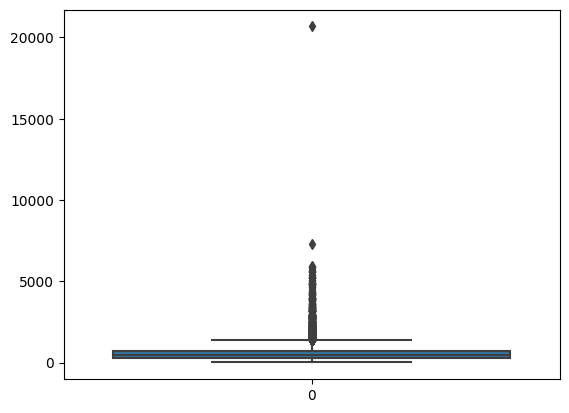

In [30]:
sns.boxplot(text_length_list)
print(f"The mean length is {round(np.mean(text_length_list))}")
print(f"The median length is {round(np.median(text_length_list))}")

In [54]:
overly_short_text_df = raw_df[[len(txt) < 20 for txt in raw_df["Text"]]]
overly_short_text_df.head(5)

,Text,Label
597,idea thread voted,0
777,say look cool,0
933,extremely common,0
1398,child still hear,0
1783,wiring,0


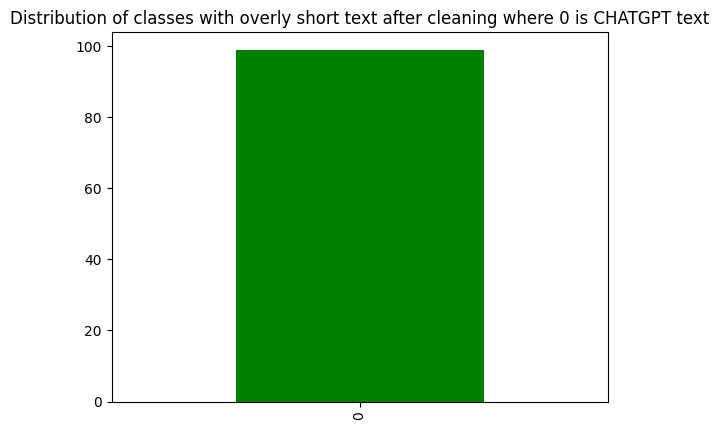

In [55]:
count_Class=pd.value_counts(overly_short_text_df["Label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Distribution of classes with overly short text after cleaning where 0 is CHATGPT text')
plt.show()

Replace TFIDF with BERT preprocessing layer

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [29]:
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 84.8 MB/s eta 0:00:00


In [30]:
#Reference: https://predictivehacks.com/?all-tips=how-to-get-bert-embeddings-with-tensorflow-hub

# Define the model
BERT_MODEL = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1" 
# Choose the preprocessing that must match the model
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)

In [31]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['sequence_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(net)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(net)
dense = tf.keras.layers.Dense(64, activation='relu')(lstm)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model_bert = tf.keras.models.Model(text_input, outputs=output)

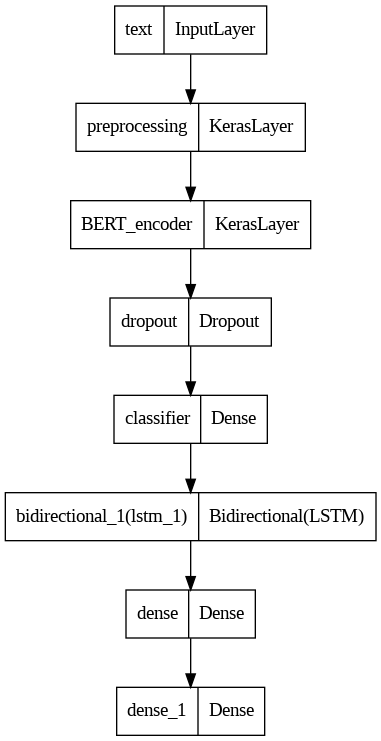

In [ ]:
tf.keras.utils.plot_model(model, to_file='BERT_RNN.png')

Prepare uncleaned data for input into BERT

In [32]:
X = raw_df['response'].values
y = raw_df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

train_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_train, tf.string),tf.cast(y_train, tf.int32))))
test_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_test, tf.string),tf.cast(y_test, tf.int32))))

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Compile Model

In [33]:
model_bert.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy', 'AUC'])

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model_bert.fit(train_dataset,epochs=2,validation_data=test_dataset,validation_steps=30,callbacks=[early_stop])

Epoch 1/5
363/363 [==============================] - 246s 592ms/step - loss: 0.2095 - accuracy: 0.9436 - auc: 0.9856 - val_loss: 0.0950 - val_accuracy: 0.9740 - val_auc: 0.9954
Epoch 2/5
363/363 [==============================] - 209s 575ms/step - loss: 0.0347 - accuracy: 0.9904 - auc: 0.9984 - val_loss: 0.0420 - val_accuracy: 0.9875 - val_auc: 0.9969
Epoch 3/5
363/363 [==============================] - 203s 559ms/step - loss: 0.0195 - accuracy: 0.9944 - auc: 0.9996 - val_loss: 0.0370 - val_accuracy: 0.9906 - val_auc: 0.9966
Epoch 4/5
363/363 [==============================] - 201s 554ms/step - loss: 0.0155 - accuracy: 0.9958 - auc: 0.9993 - val_loss: 0.0360 - val_accuracy: 0.9859 - val_auc: 0.9983
Epoch 5/5
363/363 [==============================] - 203s 561ms/step - loss: 0.0094 - accuracy: 0.9972 - auc: 0.9997 - val_loss: 0.0560 - val_accuracy: 0.9854 - val_auc: 0.9943


Evaluate Model

156/156 [==============================] - 5s 34ms/step - loss: 1.2305 - accuracy: 0.6474 - auc: 0.8520
[1.2304823398590088, 0.6473721265792847, 0.8519830703735352]
156/156 [==============================] - 3s 21ms/step


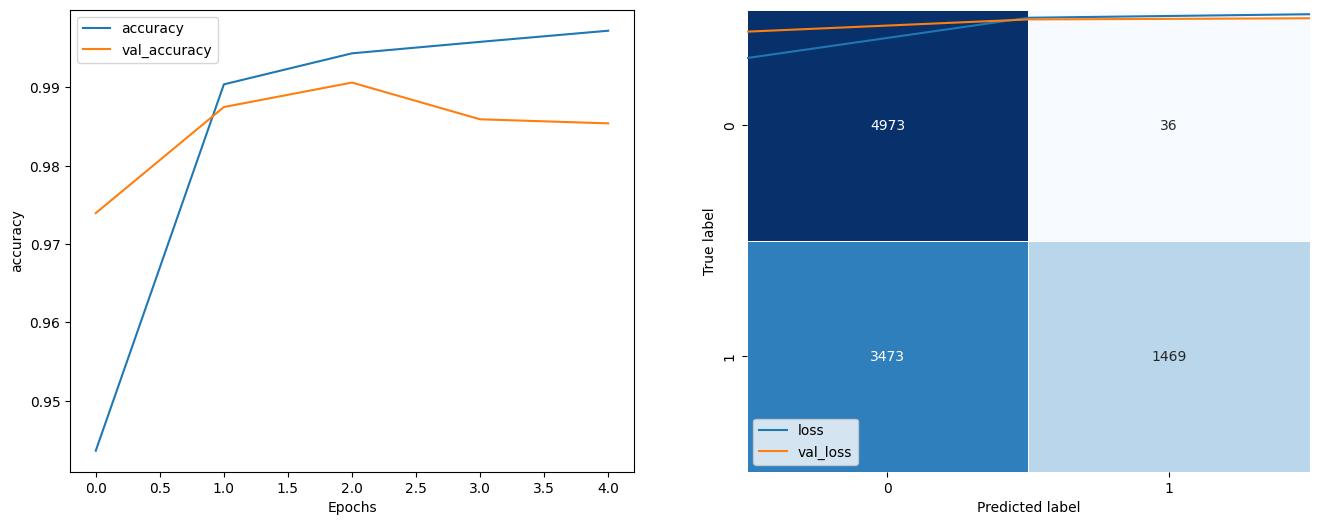

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

test_result = model.evaluate(test_dataset)
print(test_result)

preds = (model.predict(test_dataset) > 0.5).astype("int32")
plot_confusion_matrix(y_test, preds)